# Investment Risk Measurement

In [1]:
from math import sqrt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

## Available data.

In [2]:
df = pd.read_csv('../data/DVA.csv')
df = df[::12]
df.reset_index(drop=True, inplace=True)

# Assessment of the real and normal distribution

In [3]:
df['yield'] = df['Close'].pct_change() * 100
df.loc[:, ['Open', 'Close', 'Date','yield']]

,Open,Close,Date,yield
0,3.475000,4.075000,1995-10-01,NaN
1,7.950000,7.800000,1996-10-01,91.411043
2,10.050000,10.270833,1997-10-01,31.677346
3,8.000000,8.166667,1998-10-01,-20.486810
4,2.458333,2.437500,1999-10-01,-70.153062
5,2.479167,3.750000,2000-10-01,53.846154
6,6.783333,6.066667,2001-10-01,61.777787
7,7.966667,7.990000,2002-10-01,31.703289
8,10.583333,11.700000,2003-10-01,46.433041
9,15.475000,14.810000,2004-10-01,26.581197


### Expected value

In [4]:
mu = df['yield'].mean()

### Dispersion and Standard Deviation

In [5]:
dispersion = df['yield'].var()
sigma = sqrt(dispersion)

### Skewness and Kurtosis

In [6]:
skew = df['yield'].skew()
kurtosis = df['yield'].kurt()

## Comparison of the real and normal distribution

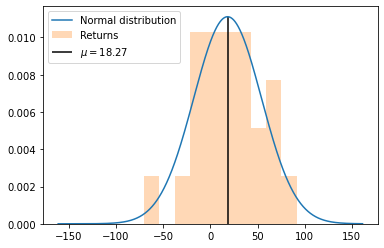

In [7]:
mn = mu - 5 * sigma 
xs = sorted(np.arange(mn, -mn, .05))
ys = [norm.pdf(x, mu, sigma) for x in xs]
h = sorted(np.asarray(df['yield'].dropna()))
plt.plot(xs, ys, label='Normal distribution')
plt.vlines(mu, 0, max(ys), label=f'$\mu = {mu:.2f}$')
plt.hist(h, density=True, histtype='stepfilled', alpha=0.3, label='Returns')
plt.rcParams['figure.figsize'] = [10, 5]
plt.legend()
plt.show()

## Probability of profitability within the specified limits

In [8]:
def calc_returns(mu, sigma, i):
    dt = mu - sigma*(i+1)
    dt2 = mu + sigma*(i+1)
    if dt > -100:
        return (
            {'dt':dt}, 
            {'dt2': dt2}, 
            {'probability':norm.cdf(dt2, mu, sigma) - norm.cdf(dt, mu, sigma)}
        )
    else: 
        return (
            {'dt':-100}, 
            {'dt2':dt2}, 
            {'probability':norm.cdf(dt2, mu, sigma) - norm.cdf(dt, mu, sigma)}
        )

lst = [calc_returns(mu, sigma, i) for i in range(3)]

In [9]:
ll = [f'\nProbability={i[2]["probability"]:.2%} for values: {i[0]["dt"]:.2f} and {i[1]["dt2"]:.2f}' for i in lst]
print(
    f'\nmu={mu:.2f}', 
    f'\nsigma={sigma:.2f}', 
    f'\nskew={skew:.2f}', 
    f'\nkurtosis={kurtosis:.2f}'
)
print(*ll)
print(f'Bankrupt risk={norm.cdf(-100, mu, sigma):.9%}')


mu=18.27 
sigma=35.91 
skew=-0.19 
kurtosis=0.39

Probability=68.27% for values: -17.64 and 54.18 
Probability=95.45% for values: -53.55 and 90.09 
Probability=99.73% for values: -89.47 and 126.00
Bankrupt risk=0.049501474%


## Change in annual profitability at various time intervals

In [10]:
def calc_period(year):
    if year == 1:
        return df['yield'].max(), df['yield'].mean(), df['yield'].min() 
    p_df = pd.DataFrame()
    length = len(df)
    n = 0
    for i in range(length):
        while i+year < length:
            start_price = df.loc[i,'Close']
            end_price = df.loc[i+year,'Close']
            p_df.loc[i+n,'Close'] = start_price
            p_df.loc[i+n+1,'Close'] = end_price
            # среднегодовая доходность
            p_df.loc[i+n+1,'yield'] = (pow((end_price/start_price), 1/(year+1)) - 1)*100 
            n += year
            break
    return  p_df['yield'].max(), p_df['yield'].mean(), p_df['yield'].min()
    

In [11]:
tbl_constr = {
    'Annual percentage yield': ['Max', 'Mean', 'Min'], 
    '1 year': calc_period(1),
    '3 years': calc_period(3),
    '5 years': calc_period(5),
    '7 years': calc_period(7),
    '10 years': calc_period(10)
}
tbl_df = pd.DataFrame(data=tbl_constr)
tbl_df

,Annual percentage yield,1 year,3 years,5 years,7 years,10 years
0,Max,91.411043,34.555216,36.811061,35.571002,24.231447
1,Mean,18.268563,9.095324,11.197766,13.063633,13.860241
2,Min,-70.153062,-25.232561,-4.668688,0.510686,5.821738


## Diagram of annual profitability at various time intervals

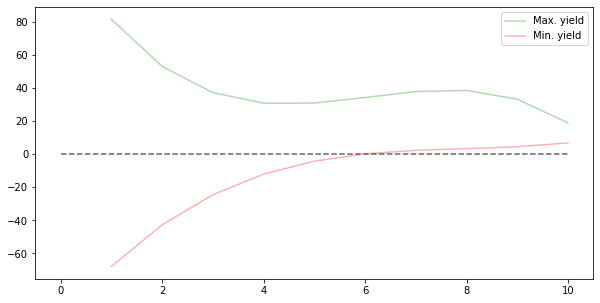

In [12]:
xs = sorted(np.arange(1, 11, 1))
ys_max = [calc_period(x)[0] for x in xs]
ys_min = [calc_period(x)[2] for x in xs]

from scipy.interpolate import splrep, splev

bspl_max = splrep(xs, ys_max, s=1000)
bspl_y_max = splev(xs, bspl_max)

bspl_min = splrep(xs, ys_min, s=1000)
bspl_y_min = splev(xs, bspl_min)

plt.plot(xs, bspl_y_max, label='Max. yield', alpha=0.3, color='green')
plt.plot(xs, bspl_y_min, label='Min. yield', alpha=0.3, color='red')
plt.hlines(0, 0, 10, label=f'', alpha=0.6, linestyle='--')
plt.rcParams['figure.figsize'] = [10, 5]
plt.legend()
plt.show()